# Lorenz system

## The problem
* When the inference process is started at true parameter values, the results are as nice as they can be -- the trace plot is nice and fluffy and centered more or less around the true parameters.
* When the starting parameters are very slightly different from the true ones (though so slightly that they are almost equal), the results are still nice.
* When they are too different, then:
    * If the model is well-specified, i.e., the particle filter uses the correct measurement model, the estimates relatively quickly (after about 15000 iterations) converge to the true values and refuse to move at all. This is striking, because one would expect that once the truth has been reached, trace plot fluffiness as above would be observed. No fluffy plots though.
    * If the model is misspecified, the estimates converge to some incorrect value and again refuse to move from it.

## Model summary

We are working with a Lorenz system model found in https://projecteuclid.org/euclid.bj/1522051233, section 6. The implementation can be found at https://github.com/tomaskala/SSM/, see https://github.com/tomaskala/SSM/blob/master/ssm/mcmc.py for the actual inference algorithms and https://github.com/tomaskala/SSM/blob/master/ssm/lorenz_system.py for the model specification.

* The unknown parameters are $\boldsymbol{\theta} = \left( S, R, B, k_o \right)^\intercal$.
* The state at time $t$ is $\boldsymbol{X}_t = \left( X_{1,t}, X_{2,t}, X_{3,t} \right)^\intercal$.
* The observation vector at time $t$ is $\boldsymbol{T}_t = \left( Y_{1,t}, Y_{3,t} \right)^\intercal$.

The transition model uses a discrete-time version of some nasty stochastic differential equation. The integration step is denoted $T_e > 0$.

\begin{equation}
\begin{split}
X_{1,t} &= X_{1,t-1} - T_e S \left( X_{1,t-1} - X_{2,t-1} \right) + \sqrt{T_e} U_{1,t}, \\
X_{2,t} &= X_{2,t-1} + T_e \left( R X_{1,t-1} - X_{2,t-1} - X_{1,t-1} X_{3,t-1} \right) + \sqrt{T_e} U_{2,t}, \\
X_{3,t} &= X_{3,t-1} + T_e \left( X_{1,t-1} X_{2,t-1} - B X_{3,t-1} \right) + \sqrt{T_e} U_{3,t}, \\
\end{split}
\end{equation}

where $U_{i,t} \sim \text{N}\left(0,1\right),\ i = 1, 2, 3,\ t = 1, 2, \ldots$.

The system is observed every 40 discrete time steps,

\begin{equation}
\begin{split}
Y_{1,t} &= k_o X_{1,40t} + V_{1,t}, \\
Y_{3,t} &= k_o X_{3,40t} + V_{3,t}, \\
\end{split}
\end{equation}

where $V_{i,t} \sim \text{N}\left(0,\frac{1}{10}\right),\ i = 1, 3,\ t = 1, 2, \ldots$.

A particle filter-based model is shown below.

In [ ]:
# VARIABLE NAMES vs. SYMBOLS ABOVE
# observation_period = 40 (how often are Y_t observed from X_t)
# observation_variance = 1/10 (variance of V_{i,t})
# x = X_t, shape: (n_particles, 3)
# y = Y_t, shape: (2,)
# T = T_e
# k = k_o
class ParticleLorenzSystem(MetropolisHastingsPF):
    def _transition(self, x: np.ndarray, t: int, theta: np.ndarray) -> np.ndarray:
        observation_period = self.const["observation_period"]
        T = self.const["T"]
        sqrt_T = np.sqrt(T)
        S = theta[0]
        R = theta[1]
        B = theta[2]

        for _ in range(observation_period):
            out = np.empty_like(x)
            U = self.random_state.normal(size=x.shape)
            out[:, 0] = x[:, 0] - T * S * (x[:, 0] - x[:, 1]) + sqrt_T * U[:, 0]
            out[:, 1] = (
                x[:, 1] + T * (R * x[:, 0] - x[:, 1] - x[:, 0] * x[:, 2]) + sqrt_T * U[:, 1]
            )
            out[:, 2] = x[:, 2] + T * (x[:, 0] * x[:, 1] - B * x[:, 2]) + sqrt_T * U[:, 2]
            x = out

        assert out.shape == x.shape
        return out

    def _observation_log_prob(
        self, y: np.ndarray, x: np.ndarray, theta: np.ndarray
    ) -> np.ndarray:
        k = theta[3]
        var = self.const["observation_variance"]

        mean0 = k * x[:, 0]
        mean2 = k * x[:, 2]

        mean = np.c_[mean0, mean2]
        assert mean.shape == (self.n_particles, 2)

        out = np.sum(stats.norm.logpdf(y, loc=mean, scale=np.sqrt(var)), axis=1)
        assert out.shape == (self.n_particles,)

        return out

Similarly, an ABC-based model whose measurement model disregards the noise terms $V_{i,t}$ is as follows.

In [ ]:
class ABCLorenzSystem(MetropolisHastingsABC):
    def _transition(self, x: np.ndarray, t: int, theta: np.ndarray) -> np.ndarray:
        observation_period = self.const["observation_period"]
        T = self.const["T"]
        sqrt_T = np.sqrt(T)
        S = theta[0]
        R = theta[1]
        B = theta[2]

        for _ in range(observation_period):
            out = np.empty_like(x)
            U = self.random_state.normal(size=x.shape)
            out[:, 0] = x[:, 0] - T * S * (x[:, 0] - x[:, 1]) + sqrt_T * U[:, 0]
            out[:, 1] = (
                x[:, 1] + T * (R * x[:, 0] - x[:, 1] - x[:, 0] * x[:, 2]) + sqrt_T * U[:, 1]
            )
            out[:, 2] = x[:, 2] + T * (x[:, 0] * x[:, 1] - B * x[:, 2]) + sqrt_T * U[:, 2]
            x = out

        assert out.shape == x.shape
        return out

    def _measurement_model(self, x: np.ndarray, theta: np.ndarray) -> np.array:
        k = theta[3]
        var = self.const["observation_variance"]

        mean0 = k * x[:, 0]
        mean2 = k * x[:, 2]

        mean = np.c_[mean0, mean2]
        assert mean.shape == (self.n_particles, 2)

        return mean

The prior distributions over $\boldsymbol{\theta}$ are all uniform:

\begin{equation}
\begin{split}
S &\sim \text{U}\left( 5, 20 \right) \\
R &\sim \text{U}\left( 18, 50 \right) \\
B &\sim \text{U}\left( 1, 8 \right) \\
k_o &\sim \text{U}\left( 0.5, 3 \right) \\
\end{split}
\end{equation}

The prior distribution over the state vector at $t=0$ is $\boldsymbol{X}_0 \sim \text{N}_3 \left( \boldsymbol{X}_*, 10 \boldsymbol{I}_3 \right)$, where $\boldsymbol{X}_* = \left( -5.91652, -5.52332, 24.5723 \right)^\intercal$ is some funky value the authors claim comes from a typical run of the algorithm.

Denoting the truncated normal distribution with mean $\mu$, variance $\sigma^2$ and truncation interval $\left(a, b\right)$ by $\text{TN}\left( \mu, \sigma^2, a, b \right)$, the transition kernels are

\begin{equation}
\begin{split}
S &: \text{TN}\left( \cdot, \sigma^2_S, 5, 20 \right), \\
R &: \text{TN}\left( \cdot, \sigma^2_R, 18, 50 \right), \\
B &: \text{TN}\left( \cdot, \sigma^2_B, 1, 8 \right), \\
k_o &: \text{TN}\left( \cdot, \sigma^2_{k_o}, 0.5, 3 \right), \\
\end{split}
\end{equation}

whose means are the previous values of the corresponding parameters in the Metropolis-Hastings algorithm. The variances are set to

\begin{equation}
\left(\sigma^2_S, \sigma^2_R, \sigma^2_B, \sigma^2_{k_o} \right)^\intercal = \frac{1}{N^{3/2}} \left( 60, 60, 10, 1 \right)^\intercal,
\end{equation}

where $N = 300$ is the number of particles. The paper shows that dividing by $N^{3/2}$ is in some sense optimal, and the numbers in the parentheses are set so that parameters with bigger supports have roughly bigger variances.

The kernel densities are plotted below. Note that the truncation bounds $\left(a, b\right)$ are not rescaled according to the variances (by subtracting the mean -- here 0 -- and dividing by standard deviation) because most of the kernels would disappear from the plot for being too narrow. It is done during the computations however, since SciPy does not bother to do this automatically.

/home/tomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


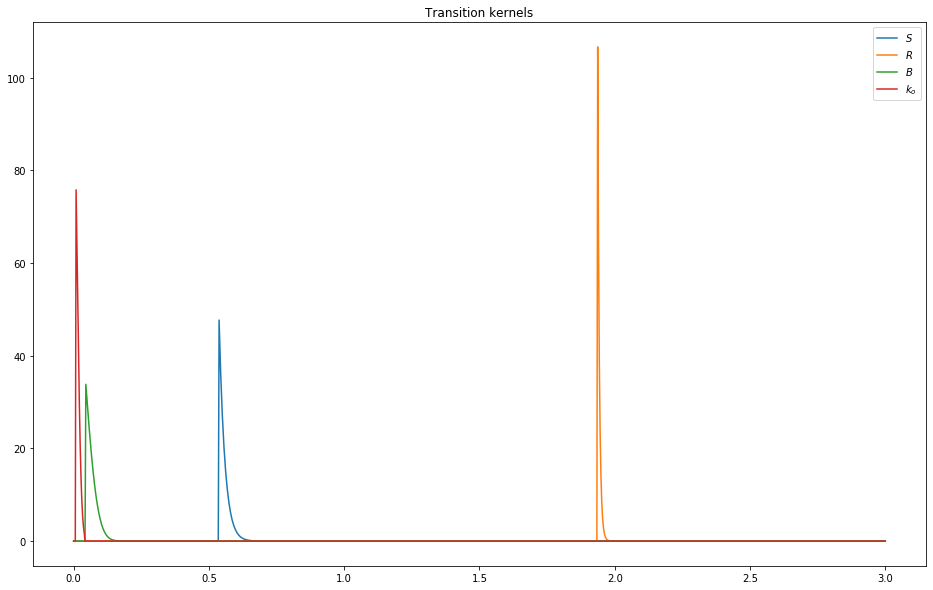

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

n_particles = 300
params = ["$S$", "$R$", "$B$", "$k_o$"]
lower = np.array([5, 18, 1, 0.5])
upper = np.array([20, 50, 8, 3])
variances = np.array([60, 60, 10, 1]) / (n_particles ** (3 / 2))

fig, ax = plt.subplots(1, figsize=(16, 10))
x = np.linspace(0, 3, 1000)

for p, a, b, v in zip(params, lower, upper, variances):
    scale = np.sqrt(v)
    tn = stats.truncnorm(loc=0, scale=scale, a=a, b=b)
    
    ax.plot(x, tn.pdf(x), label=p)

ax.set_title("Transition kernels")
ax.legend()
fig.show()

Some additional details, all exactly as in the paper.

* The experiments are performed using 600 observations, meaning 600*40 = 24000 time steps (since an observation is taken only every 40th time step), exactly as in the paper.
    * In the GitHub repo, there are 100 observations, but this value was changed before running the script on cluster.
* The number of particles is $N = 300$.
* The data are simulated from true values $\boldsymbol{\theta} = \left( 10, 28, 8/3, 4/5 \right)^\intercal$.
* The initial $\boldsymbol{\theta}_0$ for the inference process is obtained by corrupting the components of the true $\boldsymbol{\theta}$ by a zero-centered truncated-normal noise, where the truncation intervals are exactly the same as the prior distributions.
    * On cluster, the scale of this corruption distribution was set to 5. This led to poor results.
    * At least on my machine when limited to 100 observations and 10000 iterations, scales up to 2 led to nice results, but this is simply because the starting values were not far from the true ones.

## Relevant code pieces
All found in https://github.com/tomaskala/SSM/blob/master/ssm/mcmc.py, though they have been slightly edited to make more sense out of context.

### Metropolis-Hastings

In [1]:
def do_inference(self, y):  # `y` is the sequence of observations.
    theta = ...  # Initialize to `\theta_0` as described above.

    thetas = np.zeros(shape=(n_samples, theta.shape[0]), dtype=float)
    loglik = -1e99

    for i in range(n_samples):
        theta_prop = proposal.sample(theta)
        log_ratio = 0.0

        log_ratio += prior.log_prob(theta_prop)
        log_ratio -= prior.log_prob(theta)

        log_ratio += proposal.log_prob(theta, theta_prop)
        log_ratio -= proposal.log_prob(theta_prop, theta)

        loglik_prop = log_likelihood_estimate(y, theta_prop)  # Either of the two functions given below (particle or ABC).
        log_ratio += loglik_prop
        log_ratio -= loglik

        if math.log(rand()) < log_ratio:
            theta = theta_prop
            loglik = loglik_prop

        thetas[i] = theta

    return thetas

### Particle filter-based likelihood estimate

In [ ]:
# This function uses the particle filter to estimate the log-likelihood, as described
# for example in Schoen's paper at http://user.it.uu.se/~thosc112/schonsml2017.pdf.
def log_likelihood_estimate(self, y, theta):
    x = ...  # The initial state `x_0` expanded to shape (n_particles, x_shape).

    assert x.ndim == 2 and x.shape[0] == n_particles
    T = y.shape[0]  # Number of observations.
    x_dim = x.shape[1]
    loglik = 0.0

    for t in range(T):
        # Perform transition.
        x = self._transition(x, t + 1, theta)  # Defined in the `ParticleLorenzSystem` class above.
        assert x.ndim == 2 and x.shape == (self.n_particles, x_dim)

        # Evaluate the observation log probability.
        lw = self._observation_log_prob(y[t], x, theta)  # Defined in the `ParticleLorenzSystem` class above.
        assert lw.ndim == 1 and lw.shape == (self.n_particles,)
        loglik += logsumexp(lw)

        # Multinomial resampling.
        rows = self.random_state.choice(
            n_particles, n_particles, replace=True, p=softmax(lw)
        )
        x = x[rows]

    # Equation (32) from Schoen's paper in the log domain.
    loglik -= T * math.log(self.n_particles)
    return loglik

### ABC-based likelihood estimate

In [ ]:
# This function uses the ABC filter to estimate the log-likelihood.
# It comes with a bunch of utility functions.
def _log_likelihood_estimate(self, y, theta):
    x = ...  # The initial state `x_0` expanded to shape (n_particles, x_shape).

    assert x.ndim == 2 and x.shape[0] == self.n_particles
    T = y.shape[0]  # Number of observations.
    x_dim = x.shape[1]
    loglik = 0.0

    for t in range(T):
        # Perform transition.
        x = self._transition(x, t + 1, theta)  # Defined in the `ABCLorenzSystem` class above.
        assert x.ndim == 2 and x.shape == (self.n_particles, x_dim)

        # Calculate pseudo-observations.
        u = self._measurement_model(x, theta)  # Defined in the `ABCLorenzSystem` class above.
        assert (u.ndim == 1 and u.shape == (self.n_particles,)) or (
            u.ndim == 2 and u.shape == (self.n_particles, y.shape[1])
        )

        u_alpha = alphath_closest(u=u, y_t=y[t])  # Defined below.
        assert (y.ndim == 1 and isinstance(u_alpha, numbers.Number)) or (
            y.ndim == 2 and u_alpha.shape == (y.shape[1],)
        )
        tune_kernel_scales(u_alpha=u_alpha, y_t=y[t])  # Defined below.

        lw = evaluate_kernel(u=u, y_t=y[t])  # Defined below.

        if np.any(np.isnan(lw)) or np.any(np.isinf(lw)):
            continue

        assert lw.ndim == 1 and lw.shape == (self.n_particles,)
        loglik += logsumexp(lw)

        # Multinomial resampling.
        rows = self.random_state.choice(
            self.n_particles, self.n_particles, replace=True, p=softmax(lw)
        )
        x = x[rows]

    # Equation (32) from Schoen's paper in the log domain.
    loglik -= T * math.log(self.n_particles)
    return loglik


def alphath_closest(self, u, y_t):
    # Alpha denotes the number of pseudo-measurements covered by the p-HPR of the kernel. However,
    # indexing is 0-based, so we subtract 1 to get the alphath closest pseudo-measurement to y.
    if isinstance(self.kernel, Kernel):
        # Univariate observations -> single kernel.
        dists = np.abs(u - y_t)
        alphath_closest_idx = np.argpartition(
            dists, kth=self.n_particles_covered - 1, axis=-1
        )[self.n_particles_covered - 1]
        return u[alphath_closest_idx]
    else:
        # Multivariate observations -> one kernel per y-dimension.
        dists = np.abs(u - y_t[np.newaxis, :])
        alphath_closest_idx = np.argpartition(
            dists, kth=self.n_particles_covered - 1, axis=0
        )[self.n_particles_covered - 1]

        y_dim = y_t.shape[0]
        assert alphath_closest_idx.shape == (y_dim,)
        return u[alphath_closest_idx, np.arange(y_dim)]


def tune_kernel_scales(self, u_alpha, y_t):
    # The details are as in your paper and can be found in the `Kernel` class in the `mcmc.py` file.
    if isinstance(self.kernel, Kernel):
        # Univariate observations -> single kernel.
        self.kernel.tune_scale(u=u_alpha, y=y_t)
    else:
        # Multivariate observations -> one kernel per y-dimension.
        for i, kernel in enumerate(self.kernel):
            kernel.tune_scale(u=u_alpha[i], y=y_t[i])


def evaluate_kernel(self, u, y_t):
    if isinstance(self.kernel, Kernel):
        # Univariate observations -> single kernel.
        return self.kernel(u=u, y=y_t)
    else:
        # Multivariate observations -> one kernel per y-dimension. Assume independent y-dimensions.
        lws = np.array(
            [kernel(u=u[:, i], y=y_t[i]) for i, kernel in enumerate(self.kernel)]
        )
        return np.sum(lws, axis=0)